In [33]:
from typing import List, Optional

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts
from qiskit.visualization import plot_histogram

import warnings
warnings.filterwarnings("ignore")

In [2]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()

hub = "ibm-q"
group = "open"
project = "main"
hgp = f"{hub}/{group}/{project}"
backend_name = "ibm_perth"

backend = provider.get_backend(backend_name, instance=hgp)
print(f"Using {backend.name}")

Using ibm_perth


In [3]:
# Setup a base quantum circuit for our experiments
qreg_data = QuantumRegister(3)
qreg_measure = QuantumRegister(2)
creg_data = ClassicalRegister(3)
creg_syndrome = ClassicalRegister(2)
state_data = qreg_data[0]
ancillas_data = qreg_data[1:]

def build_qc() -> QuantumCircuit:
    return QuantumCircuit(qreg_data, qreg_measure, creg_data, creg_syndrome)

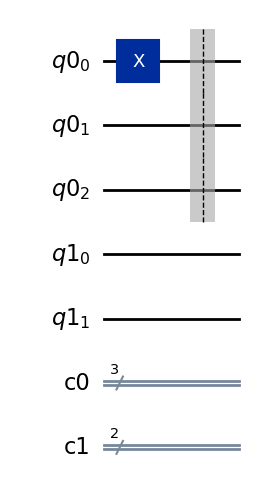

In [4]:
qc_init = build_qc()

qc_init.x(qreg_data[0])
qc_init.barrier(qreg_data)

qc_init.draw(output="mpl")

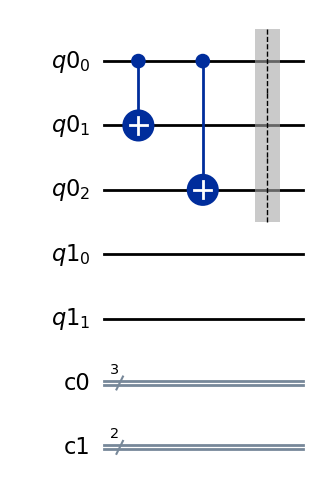

In [5]:
def encode_bit_flip(qc, state, ancillas):
    control = state
    for ancilla in ancillas:
        qc.cx(control, ancilla)
    qc.barrier(state, *ancillas)
    return qc

qc_encode_bit = build_qc()

encode_bit_flip(qc_encode_bit, state_data, ancillas_data)

qc_encode_bit.draw(output="mpl")

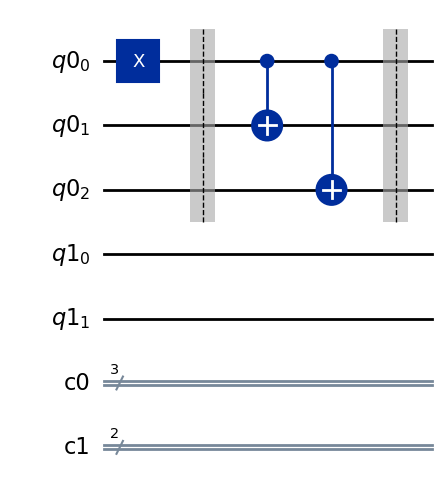

In [6]:
qc_encoded_state_bit = qc_init.compose(qc_encode_bit)
qc_encoded_state_bit.draw(output="mpl")

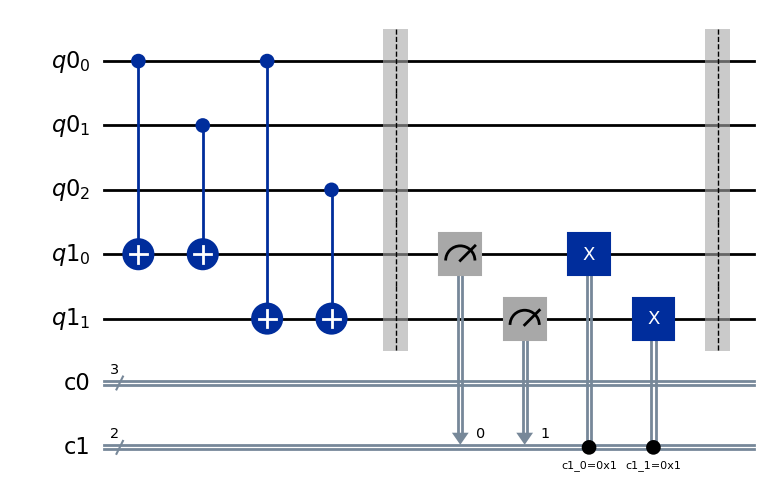

In [7]:
def measure_syndrome_bit(qc, qreg_data, qreg_measure, creg_measure): 
    qc.cx(qreg_data[0], qreg_measure[0])
    qc.cx(qreg_data[1], qreg_measure[0])
    qc.cx(qreg_data[0], qreg_measure[1])
    qc.cx(qreg_data[2], qreg_measure[1])
    qc.barrier(*qreg_data, *qreg_measure)
    qc.measure(qreg_measure, creg_measure)
    qc.x(qreg_measure[0]).c_if(creg_measure[0], 1)
    qc.x(qreg_measure[1]).c_if(creg_measure[1], 1)
    qc.barrier(*qreg_data, *qreg_measure)
    return qc

qc_syndrome_bit = measure_syndrome_bit(build_qc(), qreg_data, qreg_measure, creg_syndrome)
qc_syndrome_bit.draw(output="mpl")

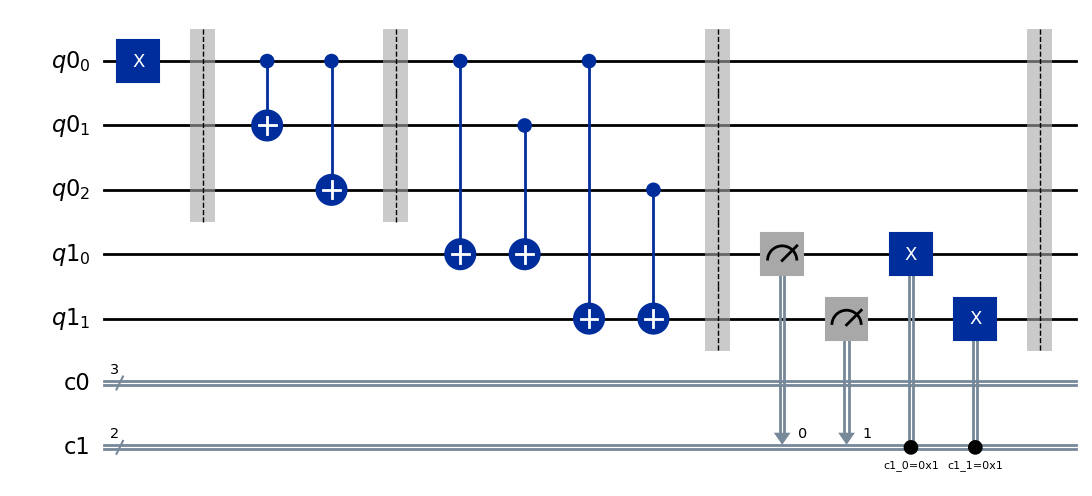

In [8]:
qc_measure_syndrome_bit = qc_encoded_state_bit.compose(qc_syndrome_bit)
qc_measure_syndrome_bit.draw(output="mpl")

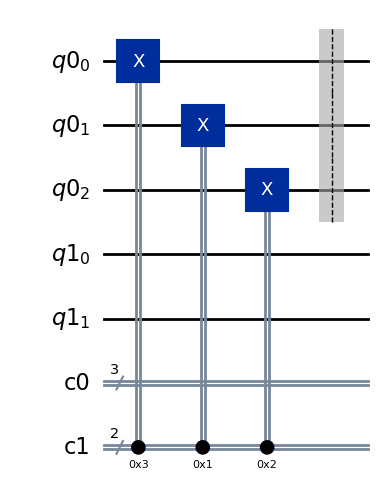

In [9]:
def apply_correction_bit(qc, qreg_data, creg_syndrome):
    qc.x(qreg_data[0]).c_if(creg_syndrome, 3)
    qc.x(qreg_data[1]).c_if(creg_syndrome, 1)
    qc.x(qreg_data[2]).c_if(creg_syndrome, 2)
    qc.barrier(qreg_data)
    return qc
    
qc_correction_bit = apply_correction_bit(build_qc(), qreg_data, creg_syndrome)
qc_correction_bit.draw(output="mpl")

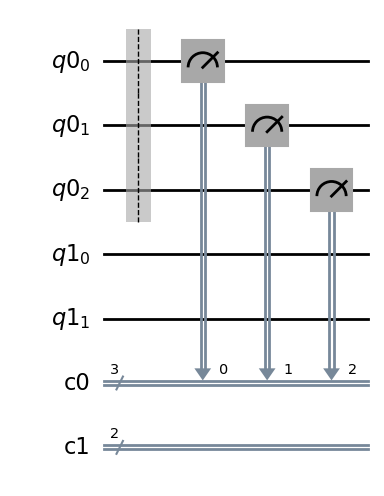

In [10]:
def apply_final_readout(qc, qreg_data, creg_data):
    qc.barrier(qreg_data)
    qc.measure(qreg_data, creg_data)
    return qc

qc_final_measure = apply_final_readout(build_qc(), qreg_data, creg_data)
qc_final_measure.draw(output="mpl")

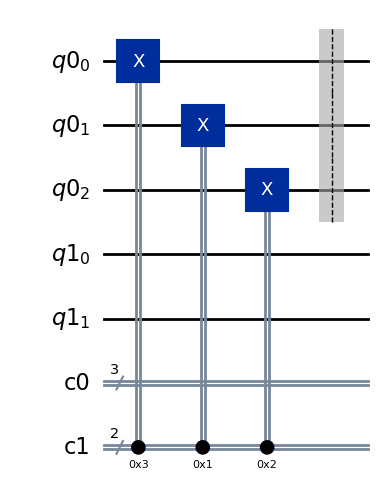

In [11]:
def apply_correction_bit(qc, qreg_data, creg_syndrome):
    qc.x(qreg_data[0]).c_if(creg_syndrome, 3)
    qc.x(qreg_data[1]).c_if(creg_syndrome, 1)
    qc.x(qreg_data[2]).c_if(creg_syndrome, 2)
    qc.barrier(qreg_data)
    return qc
    
qc_correction_bit = apply_correction_bit(build_qc(), qreg_data, creg_syndrome)
qc_correction_bit.draw(output="mpl")

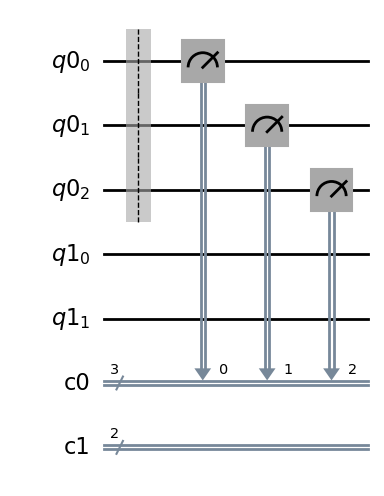

In [12]:
def apply_final_readout(qc, qreg_data, creg_data):
    qc.barrier(qreg_data)
    qc.measure(qreg_data, creg_data)
    return qc

qc_final_measure = apply_final_readout(build_qc(), qreg_data, creg_data)
qc_final_measure.draw(output="mpl")

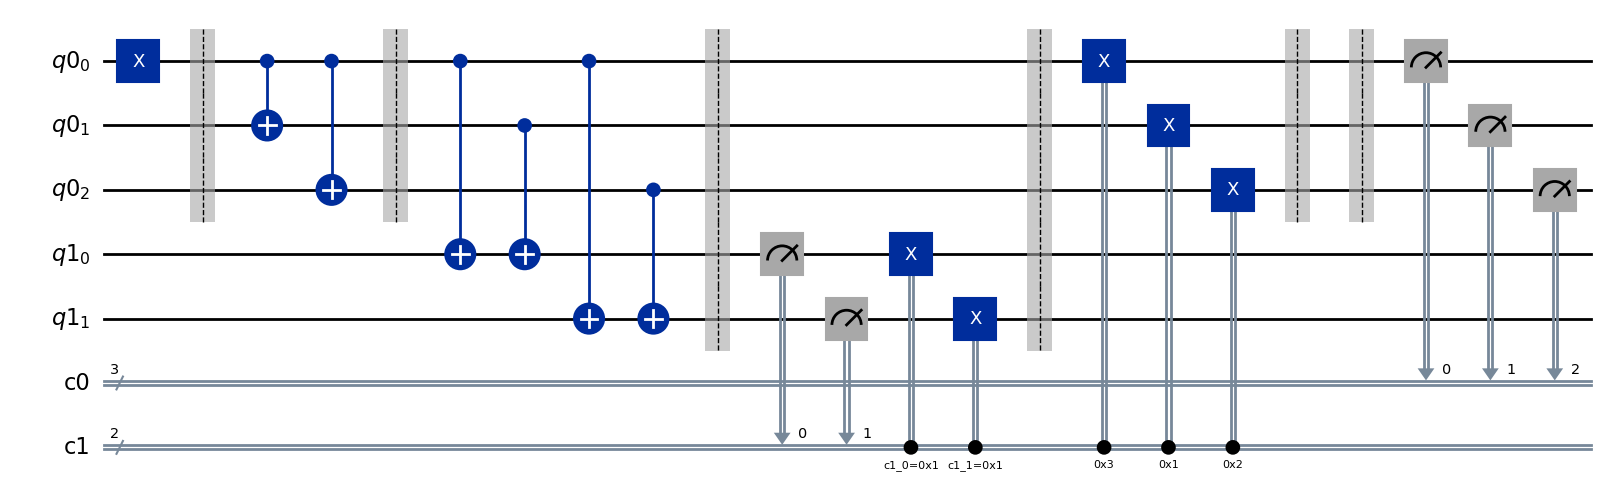

In [13]:
bit_code_circuit = qc_measure_syndrome_bit.compose(qc_correction_bit).compose(qc_final_measure)
bit_code_circuit.draw(output="mpl")

In [14]:
def build_error_correction_sequence(
    qc_base: QuantumCircuit,
    qc_init: Optional[QuantumCircuit], 
    qc_encode: QuantumCircuit, 
    qc_channels: List[QuantumCircuit],
    qc_syndrome: QuantumCircuit,
    qc_correct: QuantumCircuit,
    qc_decode: Optional[QuantumCircuit] = None,
    qc_final: Optional[QuantumCircuit] = None,
    name=None,
) -> QuantumCircuit:
    """Build a typical error correction circuit"""
    qc = qc_base
    
    if qc_init:
        qc = qc.compose(
            qc_init
        )
    
    qc = qc.compose(
            qc_encode
        )
    if name is not None:
        qc.name = name
    
    if not qc_channels:
        qc_channels = [QuantumCircuit(*qc.qregs)]
        
    for qc_channel in qc_channels:
        qc = qc.compose(
                qc_channel
            ).compose(
                qc_syndrome
            ).compose(
                qc_correct
            )
    if qc_decode:
        qc = qc.compose(qc_decode)
    
    if qc_final:
        qc = qc.compose(qc_final)
    
    return qc

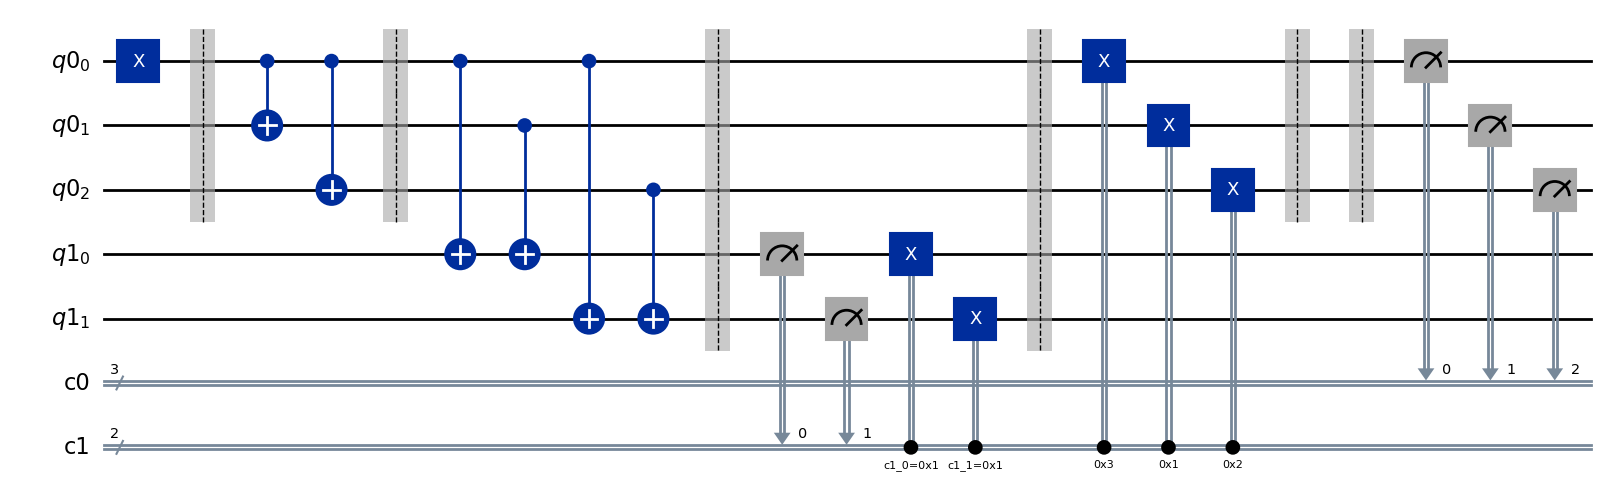

In [15]:
bit_code_circuit = build_error_correction_sequence(
    build_qc(),
    qc_init,
    qc_encode_bit,
    [],
    qc_syndrome_bit,
    qc_correction_bit,
    None,
    qc_final_measure,
)
bit_code_circuit.draw(output="mpl")

In [18]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=2
)

In [20]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(bit_code_circuit)

sampler = Sampler(backend)
job = sampler.run([isa_circuit],shots=1000)
result = job.result()

In [31]:
def decode_result(data_counts, syndrome_counts, verbose=True, indent=0):
    shots = sum(data_counts.values())
    success_trials = data_counts.get('000', 0) + data_counts.get('111', 0)
    failed_trials = shots-success_trials
    error_correction_events = shots-syndrome_counts.get('00', 0)
    
    if verbose:
        print(f"{' ' * indent}Bit flip errors were detected/corrected on {error_correction_events}/{shots} trials")
        print(f"{' ' * indent}A final parity error was detected on {failed_trials}/{shots} trials")
    return error_correction_events, failed_trials

data_result = result.data.c0.get_counts()
marginalized_syndrome_result = result.data.c1.get_counts()

print(f'Completed bit code experiment data measurement counts: {data_result}')
print(f'Completed bit code experiment syndrome measurement counts: {marginalized_syndrome_result}')
decode_result(data_result, marginalized_syndrome_result)

Completed bit code experiment data measurement counts: {'010': 6, '111': 844, '101': 85, '011': 30, '100': 4, '000': 5, '110': 22, '001': 4}
Completed bit code experiment syndrome measurement counts: {'10': 13, '00': 845, '01': 129, '11': 13}
Bit flip errors were detected/corrected on 155/1000 trials
A final parity error was detected on 151/1000 trials


(155, 151)

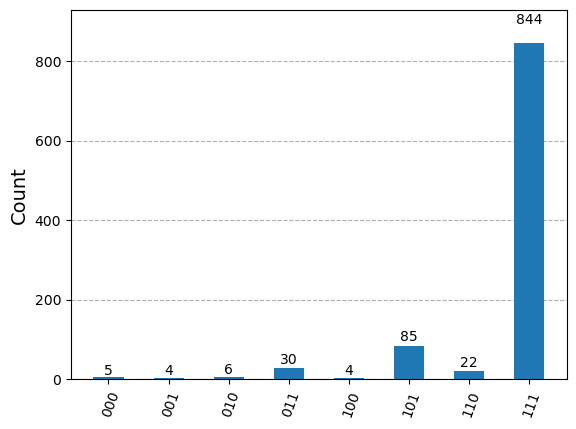

In [34]:
plot_histogram(data_result)

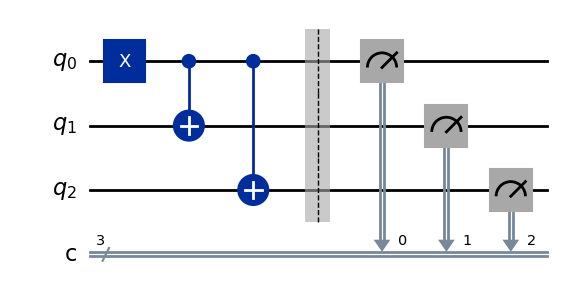

In [35]:
qc = QuantumCircuit(3,3)
qc.x(0)
qc.cx(0,1)
qc.cx(0,2)
qc.barrier()
qc.measure([0,1,2],[0,1,2])
qc.draw('mpl')

In [36]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

sampler = Sampler(backend)
job = sampler.run([isa_circuit],shots=1000)
result = job.result()

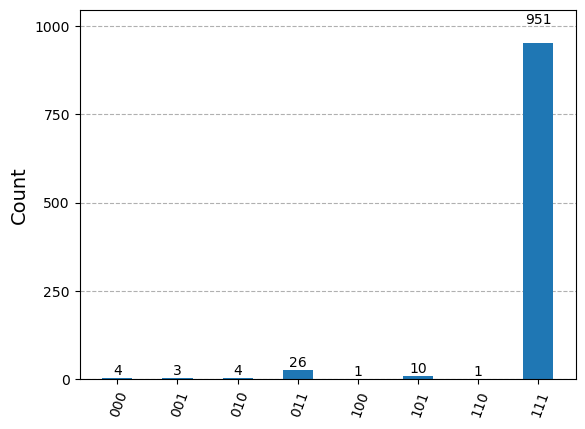

In [40]:
plot_histogram(result[0].data.c.get_counts())